## POS tagging using modified Viterbi

### 1. Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
import operator
import warnings
warnings.filterwarnings('ignore')

In [2]:
# nltk.download('universal_tagset')

In [3]:
# reading the Treebank with the 'universal' tagset.
data = nltk.corpus.treebank.tagged_sents(tagset = 'universal')

In [4]:
# first few tagged sentences
print(data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

#### Since we are asked to keep only 5% of validation data, we will act accordingly

In [5]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

3718
196
[[('While', 'ADP'), ('the', 'DET'), ('minimum', 'ADJ'), ('wage', 'NOUN'), ('had', 'VERB'), ('traditionally', 'ADV'), ('been', 'VERB'), ('pegged', 'VERB'), ('*-164', 'X'), ('at', 'ADP'), ('half', 'DET'), ('the', 'DET'), ('average', 'ADJ'), ('U.S.', 'NOUN'), ('manufacturing', 'NOUN'), ('wage', 'NOUN'), (',', '.'), ('the', 'DET'), ('level', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('4.25', 'NUM'), ('*U*', 'X'), ('an', 'DET'), ('hour', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('will', 'VERB'), ('still', 'ADV'), ('be', 'VERB'), ('less', 'ADJ'), ('than', 'ADP'), ('35', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('average', 'ADJ'), ('factory', 'NOUN'), ('pay', 'NOUN'), (',', '.'), ('Mr.', 'NOUN'), ('Williams', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('.', '.')], [('Still', 'ADV'), (',', '.'), ('many', 'ADJ'), ('economists', 'NOUN'), ('are', 'VERB'), ("n't", 'ADV'), ('predicting', 'VERB'), ('a', 'DET'), ('recession', 'NOUN'), ('anytime', 'ADV'), ('soon', 'ADV'), ('.', '.')], [('H

In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95614

#### Let's take a look at these

In [7]:
train_tagged_words

[('While', 'ADP'),
 ('the', 'DET'),
 ('minimum', 'ADJ'),
 ('wage', 'NOUN'),
 ('had', 'VERB'),
 ('traditionally', 'ADV'),
 ('been', 'VERB'),
 ('pegged', 'VERB'),
 ('*-164', 'X'),
 ('at', 'ADP'),
 ('half', 'DET'),
 ('the', 'DET'),
 ('average', 'ADJ'),
 ('U.S.', 'NOUN'),
 ('manufacturing', 'NOUN'),
 ('wage', 'NOUN'),
 (',', '.'),
 ('the', 'DET'),
 ('level', 'NOUN'),
 ('of', 'ADP'),
 ('$', '.'),
 ('4.25', 'NUM'),
 ('*U*', 'X'),
 ('an', 'DET'),
 ('hour', 'NOUN'),
 ('in', 'ADP'),
 ('1991', 'NUM'),
 ('will', 'VERB'),
 ('still', 'ADV'),
 ('be', 'VERB'),
 ('less', 'ADJ'),
 ('than', 'ADP'),
 ('35', 'NUM'),
 ('%', 'NOUN'),
 ('of', 'ADP'),
 ('average', 'ADJ'),
 ('factory', 'NOUN'),
 ('pay', 'NOUN'),
 (',', '.'),
 ('Mr.', 'NOUN'),
 ('Williams', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('*T*-1', 'X'),
 ('.', '.'),
 ('Still', 'ADV'),
 (',', '.'),
 ('many', 'ADJ'),
 ('economists', 'NOUN'),
 ('are', 'VERB'),
 ("n't", 'ADV'),
 ('predicting', 'VERB'),
 ('a', 'DET'),
 ('recession', 'NOUN'),
 ('anytime', 

#### Creating tokens

In [8]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['While',
 'the',
 'minimum',
 'wage',
 'had',
 'traditionally',
 'been',
 'pegged',
 '*-164',
 'at']

### Checking vocabulary and its length

In [9]:
# vocabulary
V = set(tokens)
print(len(V))

12078


In [10]:
V

{'accountability',
 'politely',
 'cranked',
 'Primerica',
 'money-market',
 'viewership',
 'downgrade',
 'torn',
 'elementary',
 '90',
 'investigating',
 'otherwise',
 'syndrome',
 'Rotie',
 'Choose',
 'causes',
 'Facilities',
 'Asia',
 'ugly',
 'highest',
 'fractionally',
 'There',
 'read',
 'respected',
 '16.05',
 'children',
 'fend',
 'possessed',
 'Marubeni',
 'accident',
 'preclude',
 'sells',
 '*T*-218',
 'April',
 'composting',
 'rhythm',
 'tightening',
 '1986',
 '6.03',
 'resent',
 'unanticipated',
 'Current',
 'railing',
 'reserved',
 'paycheck',
 'Drug',
 'doctor',
 'involve',
 'bearish',
 'Sonnett',
 'athletic',
 'Backseat',
 'lacks',
 'multiplying',
 'result',
 'Warren',
 'unfocused',
 '1988',
 'food-industry',
 'screens',
 'aisles',
 'anecdotal',
 'ambassador',
 'Israel',
 'grant',
 'Bermuda',
 'threat',
 'alleged',
 'bells',
 'Areas',
 'ropes',
 'capture',
 'regrettable',
 'I',
 'deteriorating',
 'Prosecutors',
 'Kuvin',
 'surgeon',
 'Unicorp',
 'Tower',
 'applicability',

In [11]:
def gen_freq(text):
    #Will store the list of words
    word_list = list(V)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

#### Creating wordcloud

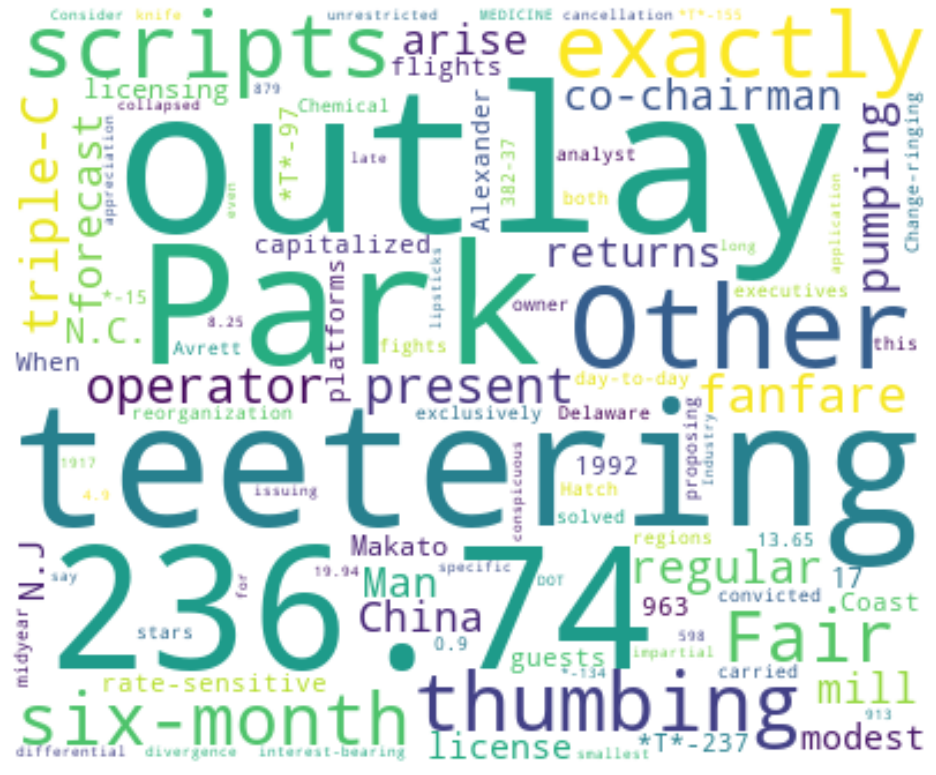

In [12]:
#Generate word frequencies
word_freq = gen_freq(V)

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(21, 14))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Checking number of tags

In [13]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [14]:
print(T)

{'X', 'NUM', 'DET', 'ADJ', 'CONJ', 'ADV', 'PRON', 'NOUN', 'ADP', '.', 'VERB', 'PRT'}


#### We are aleady given that the universal tagset of NLTK comprises only 12 coarse tag classes as follows: 
- Verb
- Noun
- Pronouns
- Adjectives
- Adverbs
- Adpositions
- Conjunctions
- Determiners
- Cardinal Numbers
- Particles
- Other/ Foreign words
- Punctuations

#### From above we can confirm that we have got the correct set of tags

## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [15]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

#### Function to compute emission probability

In [16]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [17]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUNN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(26, 6042)
(0, 12887)
(0, 0) 


 will
(1, 27441)
(271, 12887)

 book
(7, 27441)
(1, 12887)


In [18]:
print(word_given_tag('Android', 'NOUN'))

(0, 27441)


In [19]:
print(word_given_tag('Android', 'VERB'))

(0, 12887)


### Transition Probabilities

#### Function to tag Transition probabilites

In [20]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [21]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [22]:
tags_matrix

array([[7.45321885e-02, 2.69584521e-03, 5.53441159e-02, 1.71265453e-02,
        1.04662227e-02, 2.53726617e-02, 5.59784323e-02, 6.15287013e-02,
        1.45575643e-01, 1.63336501e-01, 2.04249918e-01, 1.83793217e-01],
       [2.14925379e-01, 1.87761188e-01, 3.58208944e-03, 3.22388075e-02,
        1.34328362e-02, 2.68656714e-03, 1.19402981e-03, 3.53432834e-01,
        3.49253714e-02, 1.13134332e-01, 1.79104470e-02, 2.47761197e-02],
       [4.55421694e-02, 2.18072291e-02, 5.54216886e-03, 2.03614458e-01,
        4.81927709e-04, 1.24096386e-02, 3.37349391e-03, 6.40361428e-01,
        9.27710813e-03, 1.75903607e-02, 3.97590362e-02, 2.40963855e-04],
       [2.03574970e-02, 2.08540224e-02, 4.79973527e-03, 6.78583235e-02,
        1.63853038e-02, 4.63422714e-03, 4.96524328e-04, 6.99602783e-01,
        7.64647499e-02, 6.52101934e-02, 1.27441240e-02, 1.05925193e-02],
       [8.78409576e-03, 4.06842344e-02, 1.19278781e-01, 1.14193253e-01,
        4.62320837e-04, 5.54785021e-02, 5.91770671e-02, 3.51

In [23]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [24]:
tags_df

,X,NUM,DET,ADJ,CONJ,ADV,PRON,NOUN,ADP,.,VERB,PRT
X,0.074532,0.002696,0.055344,0.017127,0.010466,0.025373,0.055978,0.061529,0.145576,0.163337,0.204250,0.183793
NUM,0.214925,0.187761,0.003582,0.032239,0.013433,0.002687,0.001194,0.353433,0.034925,0.113134,0.017910,0.024776
DET,0.045542,0.021807,0.005542,0.203614,0.000482,0.012410,0.003373,0.640361,0.009277,0.017590,0.039759,0.000241
ADJ,0.020357,0.020854,0.004800,0.067858,0.016385,0.004634,0.000497,0.699603,0.076465,0.065210,0.012744,0.010593
CONJ,0.008784,0.040684,0.119279,0.114193,0.000462,0.055479,0.059177,0.351364,0.053629,0.036061,0.156727,0.004161
ADV,0.023619,0.029607,0.069528,0.127745,0.006986,0.081504,0.014970,0.032601,0.117764,0.136061,0.346640,0.012974
PRON,0.093426,0.007305,0.009612,0.072280,0.004998,0.035755,0.007689,0.209919,0.022684,0.039216,0.484429,0.012687
NOUN,0.029445,0.009329,0.013338,0.012281,0.042783,0.016763,0.004774,0.264240,0.176670,0.239350,0.146350,0.044678
ADP,0.033886,0.062427,0.324639,0.106040,0.000855,0.013148,0.068626,0.322074,0.017424,0.040834,0.008552,0.001497
.,0.026591,0.080404,0.174779,0.043807,0.058951,0.052461,0.066162,0.222372,0.089868,0.092392,0.089778,0.002344


In [25]:
tags_df.loc['.', :]

X       0.026591
NUM     0.080404
DET     0.174779
ADJ     0.043807
CONJ    0.058951
ADV     0.052461
PRON    0.066162
NOUN    0.222372
ADP     0.089868
.       0.092392
VERB    0.089778
PRT     0.002344
Name: ., dtype: float32

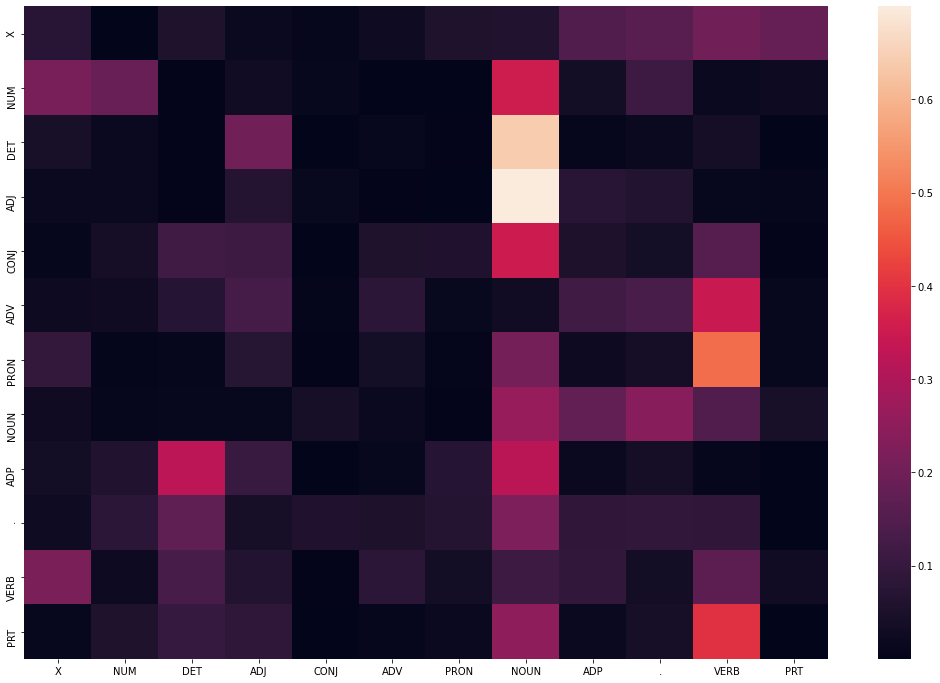

In [26]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


#### Checking frequent tags

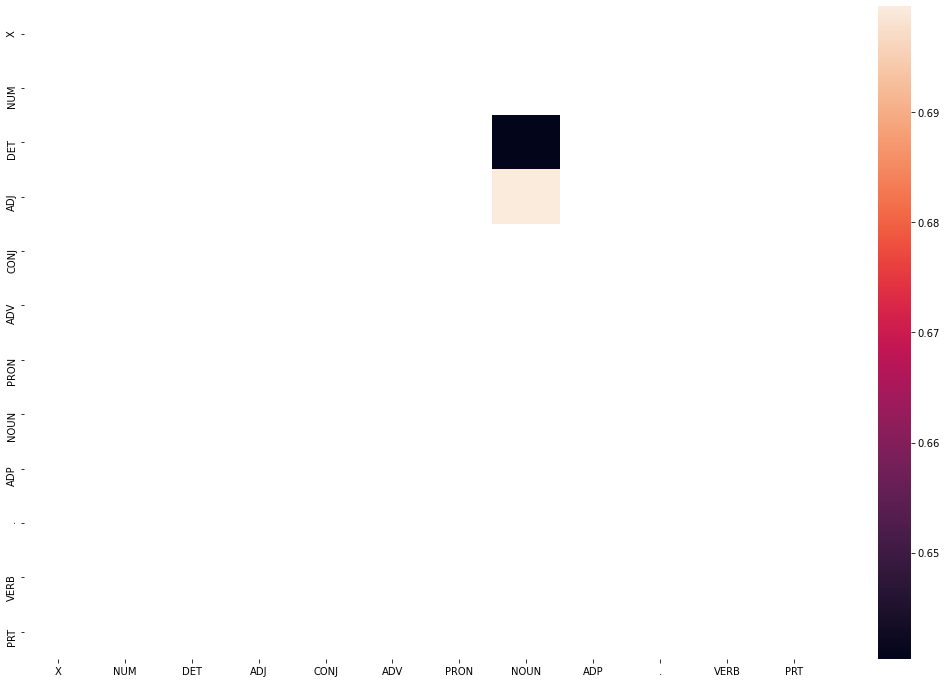

In [27]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## Build the vanilla Viterbi based POS tagger

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [28]:
len(train_tagged_words)

95614

#### Building the vanilla Viterbi based POS tagger

In [29]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [30]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Mr.', 'NOUN'),
  ('Samnick', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('a', 'DET'),
  ('guild', 'NOUN'),
  ('disciplinary', 'ADJ'),
  ('hearing', 'NOUN'),
  ('is', 'VERB'),
  ('scheduled', 'VERB'),
  ('*-1', 'X'),
  ('next', 'ADP'),
  ('Monday', 'NOUN'),
  ('in', 'ADP'),
  ('New', 'NOUN'),
  ('York', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'),
  ('Democrat', 'NOUN'),
  ("'s", 'PRT'),
  ('proposal', 'NOUN'),
  ('is', 'VERB'),
  ('described', 'VERB'),
  ('*-1', 'X'),
  ('by', 'ADP'),
  ('government', 'NOUN'),
  ('sources', 'NOUN'),
  ('and', 'CONJ'),
  ('lobbyists', 'NOUN'),
  ('as', 'ADV'),
  ('significantly', 'ADV'),
  ('weaker', 'ADJ'),
  ('than', 'ADP'),
  ('the', 'DET'),
  ('president', 'NOUN'),
  ("'s", 'PRT'),
  ('plan', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('cut', 'VERB'),
  ('utility', 'NOUN'),
  ('emissions', 'NOUN'),
  ('.', '.')],
 [('Municipal', 'ADJ'),
  ('bonds', 'NOUN'),
  ('were', 'VERB'),
  ('mostly', 'ADV'),
  ('unchanged', 'ADJ'),
  ('to', 'PRT'),
  ('up', 

In [31]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [32]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  23.08988618850708
[('Mr.', 'NOUN'), ('Samnick', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('a', 'DET'), ('guild', 'NOUN'), ('disciplinary', 'ADJ'), ('hearing', 'NOUN'), ('is', 'VERB'), ('scheduled', 'VERB'), ('*-1', 'X'), ('next', 'ADJ'), ('Monday', 'NOUN'), ('in', 'ADP'), ('New', 'NOUN'), ('York', 'NOUN'), ('.', '.'), ('The', 'DET'), ('Democrat', 'NOUN'), ("'s", 'PRT'), ('proposal', 'NOUN'), ('is', 'VERB'), ('described', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('government', 'NOUN'), ('sources', 'NOUN'), ('and', 'CONJ'), ('lobbyists', 'NOUN'), ('as', 'ADP'), ('significantly', 'ADV'), ('weaker', 'ADJ'), ('than', 'ADP'), ('the', 'DET'), ('president', 'NOUN'), ("'s", 'PRT'), ('plan', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('cut', 'VERB'), ('utility', 'NOUN'), ('emissions', 'NOUN'), ('.', '.'), ('Municipal', 'NOUN'), ('bonds', 'NOUN'), ('were', 'VERB'), ('mostly', 'ADV'), ('unchanged', 'ADJ'), ('to', 'PRT'), ('up', 'ADV'), ('1\\/8', 'NUM'), ('point', 'NOUN'), ('in', 'ADP')

In [33]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [34]:
accuracy_plain_viterbi = len(check)/len(tagged_seq)

In [35]:
accuracy_plain_viterbi

0.9081632653061225

In [36]:
incorrect_tagged_cases_plain_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [37]:
incorrect_tagged_cases_plain_viterbi

[[('*-1', 'X'), (('next', 'ADJ'), ('next', 'ADP'))],
 [('lobbyists', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('.', '.'), (('Municipal', 'NOUN'), ('Municipal', 'ADJ'))],
 [('that', 'ADP'), (('non-farm', 'X'), ('non-farm', 'ADJ'))],
 [('by', 'ADP'), (('152,000', 'X'), ('152,000', 'NUM'))],
 [('.', '.'), (('FALL', 'X'), ('FALL', 'NOUN'))],
 [('FALL', 'NOUN'), (('BALLOT', 'X'), ('BALLOT', 'NOUN'))],
 [('BALLOT', 'NOUN'), (('ISSUES', 'X'), ('ISSUES', 'NOUN'))],
 [('for', 'ADP'), (('off-year', 'X'), ('off-year', 'ADJ'))]]

#### Checking for the data given to us

In [38]:
content = ['Android is a mobile operating system developed by Google.\n',
           'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n',
           "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n",
           'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n',
           'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n',
           'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n', 
           'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n',
           'Show me the cheapest round trips from Dallas to Atlanta\n',
           'I would like to see flights from Denver to Philadelphia.\n',
           'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n',
           'NASA invited social media users to experience the launch of ICESAT-2 Satellite.\n', '\n', '\n', '\n']
print(content)

['Android is a mobile operating system developed by Google.\n', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n', 'Show me the cheapest round trips from Dallas to Atlanta\n', 'I would like to see flights from Denver to Philadelphia.\n', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n', 'NASA invited social media users to

In [39]:
# Reading data line by line
for line in content:
    if line != '\n':
        print(line.strip())

Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite.


#### We can test our tokenizer and Viterbi alogorithm on the sample data.
#### We will create a function for that

In [40]:
def sample_test(data):  
    words = word_tokenize(data.strip())
    start = time.time()
    tagged_seq = Viterbi(words)
    end = time.time()
    difference = end-start
    return (tagged_seq,difference)

#### Testing the Viterbi algorithm on sample data

In [41]:
for sentence_test in content:
    if sentence_test != '\n':
        print(sample_test(sentence_test))
        print('\n')

([('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')], 1.825071096420288)


([('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.')], 3.2064239978790283)


([('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.')], 3.7409746646881104)


([('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on

#### We observe that the words like Android, Google etc. are not tagged correctly

#### Creating groups of the data from above except the stopwords and storing in a list

In [42]:
## Taking all the words excecpt stopwords in a list 
group = []
for line in content:
    if line != '\n':
        group.extend([word for word in line.split() if word not in stopwords.words('english')])
        group = list(set(group))

#### We will check which tags are attached to different words

In [43]:
## Function to attach tags to the relant words from the sample content
def attached_tags_old(data, group):
    dic = dict()
    for sentence_test in content:
        if sentence_test != '\n':
            tagged_sen = sample_test(sentence_test)
            for i in tagged_sen[0]:
                if (i[0] in group):
                    dic[i[0]] =  i[1]
    return dic,Counter(dic.values())


#### Getting the words and the tags frequecy

In [44]:
words, counts = attached_tags_old(content,group)

In [45]:
print(words)

{'Android': 'X', 'mobile': 'ADJ', 'operating': 'NOUN', 'system': 'NOUN', 'developed': 'VERB', 'Google': 'X', 'best-selling': 'ADJ', 'OS': 'X', 'worldwide': 'X', 'smartphones': 'X', 'since': 'ADP', '2011': 'X', 'tablets': 'NOUN', 'Twitter': 'X', 'made': 'VERB', 'deal': 'NOUN', '2015': 'X', 'gave': 'VERB', 'access': 'NOUN', 'online': 'X', 'news': 'NOUN', 'social': 'ADJ', 'networking': 'NOUN', 'service': 'NOUN', 'users': 'NOUN', 'post': 'NOUN', 'interact': 'X', 'messages': 'X', 'known': 'VERB', 'Before': 'ADP', 'entering': 'VERB', 'Donald': 'NOUN', 'Trump': 'NOUN', 'domineering': 'X', 'businessman': 'NOUN', 'television': 'NOUN', 'The': 'DET', '2018': 'X', 'FIFA': 'X', 'World': 'NOUN', 'Cup': 'X', '21st': 'X', 'international': 'ADJ', 'football': 'NOUN', 'tournament': 'X', 'contested': 'X', 'every': 'DET', 'four': 'NUM', 'This': 'DET', 'first': 'ADJ', 'held': 'VERB', 'Eastern': 'NOUN', 'Europe': 'NOUN', '11th': 'ADJ', 'time': 'NOUN', 'Show': 'NOUN', 'cheapest': 'ADJ', 'round': 'NOUN', 'trip

In [46]:
counts

Counter({'X': 23,
         'ADJ': 7,
         'NOUN': 31,
         'VERB': 9,
         'ADP': 3,
         'DET': 3,
         'NUM': 2,
         'PRON': 1})

#### Sorting by descending

In [47]:
counts = dict(sorted(counts.items(), key=operator.itemgetter(1),reverse=True))

#### Visualizing the data

In [48]:
def data_pattern(data):
    keys = list(data.keys())
    vals = [int(data[k]) for k in keys]
    plt.figure(figsize=(12, 6))
    splot= sns.barplot(x=keys, y=vals)
    for p in splot.patches:
        splot.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2, p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    plt.suptitle('Distribution of tags in the data', fontsize = 14)
    plt.xlabel("POS Tags", size=14)
    plt.ylabel("Count", size=14)
    plt.show()

#### Checking the distribution

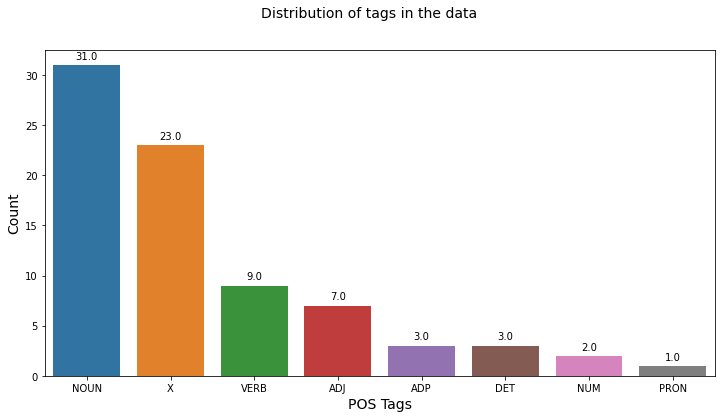

In [49]:
data_pattern(counts)

#### We can see the tagging and Viterbi algorithm are in working condition

#### Our next goal is to solve the problem of unknown words using __at least two techniques__

## Solve the problem of unknown words

#### We can use lexicon, rule-based, probabilistic etc

#### We will try these two techniques one by one
1. Using lexical techniques in the data and check accuracy
2. Tagging unknown words and checking accuracy

### Technique 1:

#### We will first start with Lexical techniques
- First we will start with Unigram Tagger
- Then we will perform Bigram Tagger with unigram as backoff
- Lastly, we will perform trigram tagger with bigram as backoff

### 5. Lexicon (Unigram) Tagger

Let's now try training a lexicon (or a unigram) tagger which assigns the most commonly assigned tag to a word. 

In NLTK, the `UnigramTagger()`  can be used to train such a model.

### 5.1. UnigramTagger

In [50]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
accuracy_unigram_tagger

0.904978269458712

Even a simple unigram tagger seems to perform fairly well. 

### 5.2. Rule-Based (Regular Expression) Tagger

Now let's build a rule-based, or regular expression based tagger. In NLTK, the `RegexpTagger()` can be provided with handwritten regular expression patterns, as shown below.

In the example below, we specify regexes for gerunds and past tense verbs (as seen above), 3rd singular present verb (creates, moves, makes etc.), modal verbs MD (should, would, could), possesive nouns (partner's, bank's etc.), plural nouns (banks, institutions), cardinal numbers CD and finally, if none of the above rules are applicable to a word, we tag the most frequent tag NN.  

In [51]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]

### 5.3. Combining Taggers

Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

NLTK provides a convenient way to combine taggers using the 'backup' argument. In the following code, we create a regex tagger which is used as a backup tagger to the lexicon tagger, i.e. when the tagger is not able to tag using the lexicon (in case of a new word not in the vocabulary), it uses the rule-based tagger. 

Also, note that the rule-based tagger itself is backed up by the tag 'NN'.


In [52]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon_tagger = lexicon_tagger.evaluate(test_set)
accuracy_lexicon_tagger

0.904978269458712

#### The accuracy has not improved much

### 5.4. Bigram Tagger

Let's now try training a bigram tagger.

In NLTK, the `BigramTagger()`  can be used to train such a model.

In [53]:
# Bigram Tagger
bigram_tagger = nltk.BigramTagger(train_set,backoff = lexicon_tagger)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger

0.9067562228368234

#### There is not much improvement. Let's try further

### 5.5. Trigram Tagger

Let's now try training a trigram tagger.

In NLTK, the `TrigramTagger()`  can be used to train such a model.

In [54]:
# Bigram Tagger
trigram_tagger = nltk.TrigramTagger(train_set,backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)

0.9069537732121691

In [55]:
print(T)

{'X', 'NUM', 'DET', 'ADJ', 'CONJ', 'ADV', 'PRON', 'NOUN', 'ADP', '.', 'VERB', 'PRT'}


#### There is only slight improvement in the accuracy
#### We need to improve on  this and so, we will apply second technique

### Technique 2:

#### Now to build this into viterbi, need to change the regex patterns to fit for the tags in our data (NOUN instead of NNS etc)

#### Function for rule based tragram tagger

In [56]:
def trigram_tagger(word,train_set = train_set):
    patterns1 = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'X'),                # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
    ]
    regex_based_tagger = nltk.RegexpTagger(patterns1)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

#### Function for modified viterbi

In [57]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in tokens:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [58]:
test_run_base = [tup for sent in test_run for tup in sent]

# list of tagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_tagged_words

['Mr.',
 'Samnick',
 'said',
 '0',
 'a',
 'guild',
 'disciplinary',
 'hearing',
 'is',
 'scheduled',
 '*-1',
 'next',
 'Monday',
 'in',
 'New',
 'York',
 '.',
 'The',
 'Democrat',
 "'s",
 'proposal',
 'is',
 'described',
 '*-1',
 'by',
 'government',
 'sources',
 'and',
 'lobbyists',
 'as',
 'significantly',
 'weaker',
 'than',
 'the',
 'president',
 "'s",
 'plan',
 '*',
 'to',
 'cut',
 'utility',
 'emissions',
 '.',
 'Municipal',
 'bonds',
 'were',
 'mostly',
 'unchanged',
 'to',
 'up',
 '1\\/8',
 'point',
 'in',
 'light',
 ',',
 'cautious',
 'trading',
 'prior',
 'to',
 'tomorrow',
 "'s",
 'unemployment',
 'report',
 '.',
 'The',
 'average',
 'estimate',
 'of',
 '22',
 'economists',
 'polled',
 '*',
 'by',
 'Dow',
 'Jones',
 'Capital',
 'Markets',
 'Report',
 'was',
 'that',
 'non-farm',
 'payrolls',
 'expanded',
 'by',
 '152,000',
 'in',
 'October',
 '.',
 'FALL',
 'BALLOT',
 'ISSUES',
 'set',
 'a',
 'record',
 'for',
 'off-year',
 'elections',
 '.']

#### Evaluating tagging accuracy

In [59]:
# tagging the test sentences
start = time.time()
tagged_seq_modified = Viterbi_modified(test_tagged_words)
end = time.time()
difference = end-start

In [60]:
print("Time taken in seconds: ", difference)
print(tagged_seq_modified)

Time taken in seconds:  33.725807905197144
[('Mr.', 'NOUN'), ('Samnick', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('a', 'DET'), ('guild', 'NOUN'), ('disciplinary', 'ADJ'), ('hearing', 'NOUN'), ('is', 'VERB'), ('scheduled', 'VERB'), ('*-1', 'X'), ('next', 'ADJ'), ('Monday', 'NOUN'), ('in', 'ADP'), ('New', 'NOUN'), ('York', 'NOUN'), ('.', '.'), ('The', 'DET'), ('Democrat', 'NOUN'), ("'s", 'PRT'), ('proposal', 'NOUN'), ('is', 'VERB'), ('described', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('government', 'NOUN'), ('sources', 'NOUN'), ('and', 'CONJ'), ('lobbyists', 'NOUN'), ('as', 'ADP'), ('significantly', 'ADV'), ('weaker', 'ADJ'), ('than', 'ADP'), ('the', 'DET'), ('president', 'NOUN'), ("'s", 'PRT'), ('plan', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('cut', 'VERB'), ('utility', 'NOUN'), ('emissions', 'NOUN'), ('.', '.'), ('Municipal', 'NOUN'), ('bonds', 'NOUN'), ('were', 'VERB'), ('mostly', 'ADV'), ('unchanged', 'ADJ'), ('to', 'PRT'), ('up', 'ADV'), ('1\\/8', 'NUM'), ('point', 'NOUN'), ('in', 'ADP'

In [61]:
# accuracy
check1 = [i for i, j in zip(tagged_seq_modified, test_run_base) if i == j]
accuracy_viterbi_modified = len(check1)/len(tagged_seq_modified)
accuracy_viterbi_modified

0.9489795918367347

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Creating a function to compare accuracy

In [62]:
def compare_accuracy():
    keys = ['accuracy_plain_viterbi','accuracy_lexicon_tagger','accuracy_unigram_tagger','accuracy_bigram_tagger','accuracy_viterbi_modified']
    vals = [accuracy_plain_viterbi,accuracy_lexicon_tagger,accuracy_unigram_tagger,accuracy_bigram_tagger,accuracy_viterbi_modified]
    plt.figure(figsize=(14, 7))
    splot= sns.barplot(x=keys, y=vals)
    for p in splot.patches:
        splot.annotate(format(p.get_height()*100, '.3f'), 
                       (p.get_x() + p.get_width() / 2, p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    plt.suptitle('Accuracy for different models', fontsize = 14)
    plt.xlabel("Model", size=14)
    plt.ylabel("Accuracy", size=14)
    plt.show()

#### Checking accuracies for different models

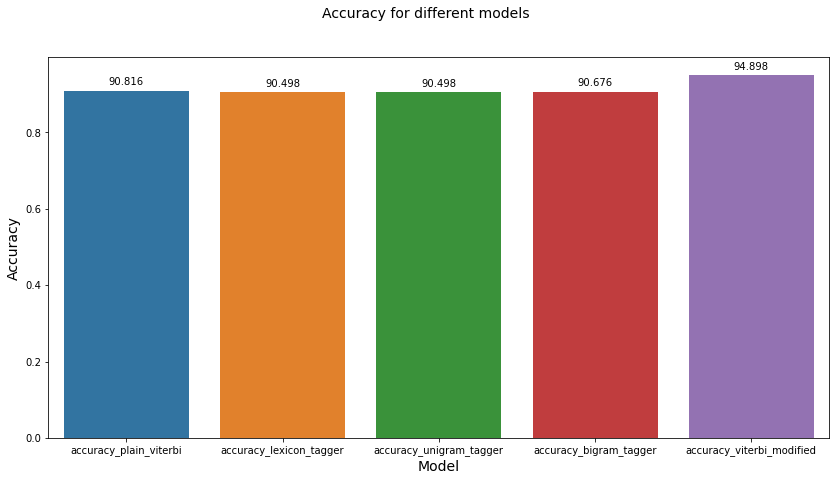

In [63]:
compare_accuracy()

#### We can clearly observe that the modified viterbi has th highest accuracy

### List down cases which were incorrectly tagged by original POS tagger and got corrected by the modifications

#### We can test our tokenizer and Viterbi alogorithm on the sample data.
#### We will create a function for that

In [64]:
def sample_test_modified(data):  
    words = word_tokenize(data.strip())
    start = time.time()
    tagged_seq = Viterbi_modified(words)
    end = time.time()
    difference = end-start
    return (tagged_seq,difference)

####  Now, we can observe what has changed in the data from modified Viterbi

In [65]:
def attached_tags_modified(data, group):
    dic = dict()
    for sentence_test in content:
        if sentence_test != '\n':
            tagged_sen = sample_test_modified(sentence_test)
            for i in tagged_sen[0]:
                if (i[0] in group):
                    dic[i[0]] =  i[1]
    return dic,Counter(dic.values())


#### We already have the test data

In [66]:
print(content)

['Android is a mobile operating system developed by Google.\n', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n', 'Show me the cheapest round trips from Dallas to Atlanta\n', 'I would like to see flights from Denver to Philadelphia.\n', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n', 'NASA invited social media users to

In [67]:
words_modified, counts_modified = attached_tags_modified(content,group)

In [68]:
print(words_modified)

{'Android': 'NOUN', 'mobile': 'ADJ', 'operating': 'NOUN', 'system': 'NOUN', 'developed': 'VERB', 'Google': 'NOUN', 'best-selling': 'ADJ', 'OS': 'NOUN', 'worldwide': 'NOUN', 'smartphones': 'VERB', 'since': 'ADP', '2011': 'NUM', 'tablets': 'NOUN', 'Twitter': 'NOUN', 'made': 'VERB', 'deal': 'NOUN', '2015': 'NUM', 'gave': 'VERB', 'access': 'NOUN', 'online': 'NOUN', 'news': 'NOUN', 'social': 'ADJ', 'networking': 'NOUN', 'service': 'NOUN', 'users': 'NOUN', 'post': 'NOUN', 'interact': 'NOUN', 'messages': 'VERB', 'known': 'VERB', 'Before': 'ADP', 'entering': 'VERB', 'Donald': 'NOUN', 'Trump': 'NOUN', 'domineering': 'VERB', 'businessman': 'NOUN', 'television': 'NOUN', 'The': 'DET', '2018': 'NUM', 'FIFA': 'NOUN', 'World': 'NOUN', 'Cup': 'NOUN', '21st': 'NOUN', 'international': 'ADJ', 'football': 'NOUN', 'tournament': 'NOUN', 'contested': 'VERB', 'every': 'DET', 'four': 'NUM', 'This': 'DET', 'first': 'ADJ', 'held': 'VERB', 'Eastern': 'NOUN', 'Europe': 'NOUN', '11th': 'ADJ', 'time': 'NOUN', 'Show'

#### We see that the words - Google, Android etc has converted to NOUN, and other tags have been corrected

#### Checking the distribution 

In [69]:
counts

{'NOUN': 31,
 'X': 23,
 'VERB': 9,
 'ADJ': 7,
 'ADP': 3,
 'DET': 3,
 'NUM': 2,
 'PRON': 1}

In [70]:
counts_modified

Counter({'NOUN': 45,
         'ADJ': 7,
         'VERB': 15,
         'ADP': 3,
         'NUM': 5,
         'DET': 3,
         'PRON': 1})

#### Sorting the data

In [71]:
counts_modified = dict(sorted(counts_modified.items(), key=operator.itemgetter(1),reverse=True))

#### Visualizing the data

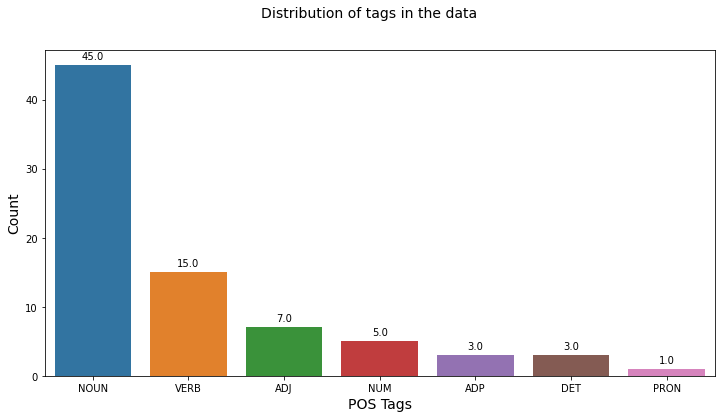

In [72]:
data_pattern(counts_modified)

#### We observe that the count for Noun and Verb has improved drastically for the same set. Also the accuracy is around 94% which is quite good.

### __Conlusion__: We can conclude that technique 2 of modified viterbi is more reliable and can be used for good results.